WORKING IN PYTHON 2.7

# Loading the Data

Commands (in same folder as 3DGenome.tar after extracting folders): 

`$ hifive fends -L genome/mm9.len --binned 100000 gen_part.fend`

`$ hifive hic-data -X data/WT_100kb/raw_*.mat gen_part.fend counts_inter.fend`

`$ hifive hic-project -f 25 -n 25 -j 100000 counts_inter.fend project.fend`

`$ hifive hic-normalize express -f 25 -w cis project.fend`

# Enrichment Scores Heatmap

### Instructions: 
For this assignment, find the fend-corrected enrichment scores and plot them with matplotlib as a heatmap for chromosome 13. Because of the scale of HiC data, it is common to take the log of values to plot or analyze
- look into using either `numpy.maximum` or `numpy.where`
- because our binsize is so large (and thus many observations per bin), you could add a pseudocount to each bin (raw and expected). A pseudocount of one would be appropriate and resolve the divide by zero issue. 

In [1]:
import hifive #this works! yay! I made a new conda env to run a python2 jupyter notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np


In [3]:
hic=hifive.HiC('project.fend', 'r')
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)

Finding fend full array for chr13:1000000-120250001... Done


In [4]:
#using np.where is too complicated, so just add to everything so no zeros
enrichment=(data[:,:,0]+0.1)/(data[:,:,1]+0.1)

In [5]:
log_enrichment = np.log(enrichment)


Text(0.5,0,'1 Mb bins')

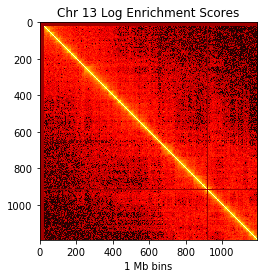

In [6]:
fig, ax = plt.subplots()

#unfortunately, can't use seaborn with py2 so found plt way:
htmap = ax.imshow(log_enrichment, cmap = 'hot')
ax.set_title("Chr 13 Log Enrichment Scores")
ax.set_xlabel("1 Mb bins")

# Compartment analysis

### Instructions :
1. Create a bed file containing compartment scores for chromosome 13 using HiFive.
2. Next, plot your compartment scores. 
3. Split genes into two groups determined by which compartment they fall at least 50% into (positive vs. negative scores) and plot each group of gene expressions separately in a violin plot in matplotlib.

In [7]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Casting complex values to real discards the imaginary part


In [8]:
! head 'hic_comp.bed' #looks like it works despite the annoying messages

chr13	3000000	3100000	-0.005205
chr13	3100000	3200000	-0.004578
chr13	3200000	3300000	0.000617
chr13	3300000	3400000	0.005744
chr13	3400000	3500000	0.017047
chr13	3500000	3600000	0.028550
chr13	3600000	3700000	0.021227
chr13	3700000	3800000	0.014095
chr13	3800000	3900000	0.019423
chr13	3900000	4000000	0.011376


In [9]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

Casting complex values to real discards the imaginary part


Text(0,0.5,'Score')

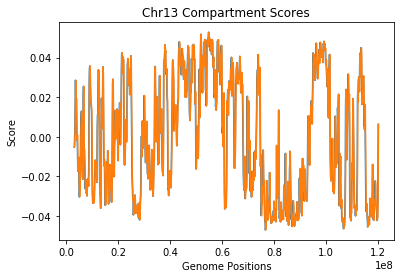

In [10]:
fig, ax = plt.subplots()
ax.plot(X, Y)
ax.set_title("Chr13 Compartment Scores")
ax.set_xlabel("Genome Positions")
ax.set_ylabel("Score")

3. Split genes into two groups determined by which compartment they fall at least 50% into (positive vs. negative scores) and plot each group of gene expressions separately in a violin plot in matplotlib.

In [11]:
#waaay easier to do in cmd than in python because only negative values have "-" in their lines

! grep -v "-" hic_comp.bed > positive.bed

! grep "-" hic_comp.bed > negative.bed

! head positive.bed

! head negative.bed

chr13	3200000	3300000	0.000617
chr13	3300000	3400000	0.005744
chr13	3400000	3500000	0.017047
chr13	3500000	3600000	0.028550
chr13	3600000	3700000	0.021227
chr13	3700000	3800000	0.014095
chr13	3800000	3900000	0.019423
chr13	3900000	4000000	0.011376
chr13	4200000	4300000	0.000928
chr13	5500000	5600000	0.001694
chr13	3000000	3100000	-0.005205
chr13	3100000	3200000	-0.004578
chr13	4000000	4100000	-0.000716
chr13	4100000	4200000	-0.001675
chr13	4300000	4400000	-0.009331
chr13	4400000	4500000	-0.017516
chr13	4500000	4600000	-0.017383
chr13	4600000	4700000	-0.012338
chr13	4700000	4800000	-0.010438
chr13	4800000	4900000	-0.016438


In [12]:
! bedtools intersect -a data/WT_fpkm.bed -b positive.bed -f 0.5 -wa > positive_exp.bed

! bedtools intersect -a data/WT_fpkm.bed -b negative.bed -f 0.5 -wa > negative_exp.bed

In [13]:
# we want the fifth columns, np makes that easy!
pos_exp = np.genfromtxt('positive_exp.bed', usecols=4)
neg_exp = np.genfromtxt('negative_exp.bed', usecols=4)


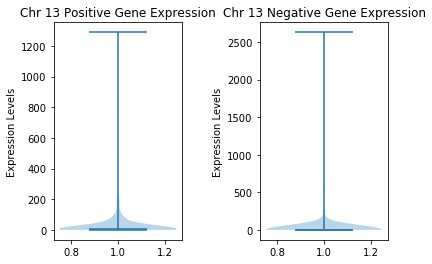

In [14]:
fig, ax = plt.subplots(ncols = 2)
ax[0].violinplot(dataset=[pos_exp],showmedians=True)
ax[0].set_ylabel("Expression Levels")
ax[0].set_title("Chr 13 Positive Gene Expression")
ax[1].violinplot(dataset=[neg_exp],showmedians=True)
ax[1].set_ylabel("Expression Levels")
ax[1].set_title("Chr 13 Negative Gene Expression")
plt.subplots_adjust(wspace = 0.6)

#this is not exactly what I expected... oh well?

# Expression vs. Repression

Extract H3K27me3 data for each gene body from chromosome 13 and plot versus expression in two plots, one for A-compartment gene set and one for B-compartment gene set. Create two scatter plots, one for each compartment, with expression on the X-axis and H3K27me3 signal on the Y-axis.

- make sure you replace the zeros  
- Use an alpha of 0.5 to show overlapping points
- see BigWig example:

In [15]:
#This box is copied from the instructions; do not edit
import pyBigWig
bw = pyBigWig.open('data/WT_H3K27me3.bw')
bw.stats('chr13', 1000000, 1200000, type='sum')

[None]

In [21]:
# make file for chr13

! grep "chr13" positive_exp.bed > chr13_fpkm_pos.bed

! grep "chr13" negative_exp.bed > chr13_fpkm_neg.bed


In [22]:
exp_data=open('chr13_fpkm_pos.bed')

gene_dict_pos={} #build expression dictionary (copied from old assignments)
for line in exp_data: 
    val = line.split('\t')
    if float(val[4]) > 0: #exclude where expression is 0
        gene_dict_pos[val[3]]=[int(val[1]),int(val[2]),float(val[4])]
    else:
        continue

exp_data_neg=open('chr13_fpkm_neg.bed')

gene_dict_neg={} #same as above
for line in exp_data_neg: 
    v = line.split('\t')
    if float(v[4]) > 0: #exclude where expression is 0
        gene_dict_neg[v[3]]=[int(v[1]),int(v[2]),float(v[4])]
    else:
        continue


Extract H3K27me3 data for each gene body from chromosome 13

In [34]:
#example:
#bw = pyBigWig.open('data/WT_H3K27me3.bw')
#bw.stats('chr13', 1100000, 1200000, type='sum')

#add methylation values to gene expression dict

bw = pyBigWig.open('data/WT_H3K27me3.bw')

pos_exp = [] #build lists from dict fpkm values
neg_exp = [] 

pos_me3 = [] #build list from H3K27me3 values, as below
neg_me3 = []

for key in gene_dict_pos: #append H3K27me3 values to dictionary
    start=gene_dict_pos[key][0]
    end=gene_dict_pos[key][1]
    me3_val=bw.stats('chr13', start, end, type='sum')
    pos_exp.append(gene_dict_pos[key][2]) #make list of fpkm values
    if me3_val is None:
        me3_val=0
    pos_me3.append((me3_val[0])) #make list of me3 values
    
for key in gene_dict_neg: #same for the second component
    start=gene_dict_neg[key][0]
    end=gene_dict_neg[key][1]
    me3_val=bw.stats('chr13', start, end, type='sum')
    neg_exp.append(gene_dict_neg[key][2]) #make list of fpkm values
    if me3_val is None:
        me3_val=0
    neg_me3.append((me3_val[0])) #make list of me3 values
    


Text(0,0.5,'H3K27me3 Signal')

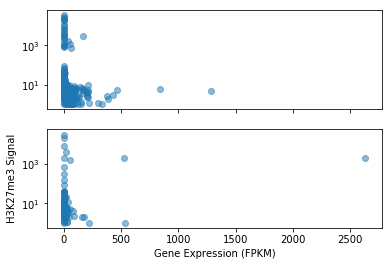

In [37]:
# Create two scatter plots, one for each compartment, with expression on the X-axis and H3K27me3 signal on the Y-axis

# Plot expression and H3K27me3
fig, ax = plt.subplots(2, sharex = True, sharey = True)
ax[0].scatter(pos_exp, pos_me3, alpha=0.5)
ax[1].scatter(neg_exp, neg_me3, alpha=0.5)
ax[0].set_yscale('log') # looks a lot better this way
ax[1].set_yscale('log')
ax[1].set_xlabel("Gene Expression (FPKM)")
ax[1].set_ylabel("H3K27me3 Signal")

